In [116]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [117]:
def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

In [118]:
def map_files(file1,file2):
  with open(file1) as f1, open(file2) as f2:
    lines1 = f1.readlines()
    lines2 = f2.readlines()
    merged_lines = [line1.strip() + '*' + line2.strip() for line1, line2 in zip(lines1, lines2)]

  with open('merged_file.txt', 'w') as f:
      for line in merged_lines:
          f.write(line + '\n')

In [119]:
def split_lines(text):
    lines = text.strip().split('\n')
    lines = [i.split('*') for i in lines]
    return lines

In [120]:
map_files("dataset.new.txt", "dataset.old.txt")

In [121]:
data = read_text("merged_file.txt")
ottoman_turkish = split_lines(data)
ottoman_turkish = array(ottoman_turkish)

In [122]:
ottoman_turkish = ottoman_turkish[:30000,:]
ottoman_turkish[1]

array(['genel durum ve görünüm : osmanli devletinin içinde bulunduğu grup , genel savaşta yenilmiş , osmanli ordusu her tarafta zedelenmiş , şartlari ağir bir ateşkes anlaşmasi imzalanmiş .',
       'vaziyet ve manzarai umumiye : osmanlı devletinin dahil bulunduğu grup , harbi umumide mağlup olmuş , osmanlı ordusu her tarafta zedelenmiş , şeraiti ağır , bir mütarekename imzalanmış .'],
      dtype='<U2067')

In [123]:
ottoman_turkish[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ottoman_turkish[:,0]]
ottoman_turkish[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ottoman_turkish[:,1]]


In [124]:
# convert text to lowercase
for i in range(len(ottoman_turkish)):
    ottoman_turkish[i,0] = ottoman_turkish[i,0].lower()
    ottoman_turkish[i,1] = ottoman_turkish[i,1].lower()

In [125]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [126]:
turkish_tokenizer = tokenization(ottoman_turkish[:, 0])
turkish_vocab_size = len(turkish_tokenizer.word_index) + 1

turkish_length = 8
print('Turkish Vocabulary Size: %d' % turkish_vocab_size)

Turkish Vocabulary Size: 31298


In [127]:
ottoman_tokenizer = tokenization(ottoman_turkish[:, 1])
ottoman_vocab_size = len(ottoman_tokenizer.word_index) + 1

ottoman_length = 8
print('Ottoman Vocabulary Size: %d' % ottoman_vocab_size)

Ottoman Vocabulary Size: 30544


In [128]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [129]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ottoman_turkish, test_size=0.2, random_state = 12)

In [130]:
# prepare training data
trainX = encode_sequences(ottoman_tokenizer, ottoman_length, train[:, 1])
trainY = encode_sequences(turkish_tokenizer, turkish_length, train[:, 0])

# prepare validation data
testX = encode_sequences(ottoman_tokenizer, ottoman_length, test[:, 1])
testY = encode_sequences(turkish_tokenizer, turkish_length, test[:, 0])

In [131]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [132]:
# model compilation
model = define_model(ottoman_vocab_size, turkish_vocab_size, ottoman_length, turkish_length, 512)

In [133]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [134]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=100, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 7.5056
Epoch 1: val_loss improved from inf to 7.18552, saving model to model.h1.24_jan_19


150/150 [==============================] - 20s 109ms/step - loss: 7.5056 - val_loss: 7.1855
Epoch 2/100
146/150 [============================>.] - ETA: 0s - loss: 6.8892
Epoch 2: val_loss improved from 7.18552 to 6.89471, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 6.8861 - val_loss: 6.8947
Epoch 3/100
146/150 [============================>.] - ETA: 0s - loss: 6.5380
Epoch 3: val_loss improved from 6.89471 to 6.74048, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 6.5389 - val_loss: 6.7405
Epoch 4/100
146/150 [============================>.] - ETA: 0s - loss: 6.2818
Epoch 4: val_loss improved from 6.74048 to 6.60364, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 6.2828 - val_loss: 6.6036
Epoch 5/100
146/150 [============================>.] - ETA: 0s - loss: 6.0210
Epoch 5: val_loss improved from 6.60364 to 6.39896, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 6.0216 - val_loss: 6.3990
Epoch 6/100
146/150 [============================>.] - ETA: 0s - loss: 5.7389
Epoch 6: val_loss improved from 6.39896 to 6.26703, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 5.7406 - val_loss: 6.2670
Epoch 7/100
150/150 [==============================] - ETA: 0s - loss: 5.4500
Epoch 7: val_loss improved from 6.26703 to 6.14587, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 5.4500 - val_loss: 6.1459
Epoch 8/100
150/150 [==============================] - ETA: 0s - loss: 5.1528
Epoch 8: val_loss improved from 6.14587 to 5.96366, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 5.1528 - val_loss: 5.9637
Epoch 9/100
146/150 [============================>.] - ETA: 0s - loss: 4.8537
Epoch 9: val_loss improved from 5.96366 to 5.82863, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 4.8568 - val_loss: 5.8286
Epoch 10/100
146/150 [============================>.] - ETA: 0s - loss: 4.5515
Epoch 10: val_loss improved from 5.82863 to 5.73595, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 4.5582 - val_loss: 5.7360
Epoch 11/100
146/150 [============================>.] - ETA: 0s - loss: 4.2530
Epoch 11: val_loss improved from 5.73595 to 5.58076, saving model to model.h1.24_jan_19


150/150 [==============================] - 14s 94ms/step - loss: 4.2565 - val_loss: 5.5808
Epoch 12/100
146/150 [============================>.] - ETA: 0s - loss: 3.9602
Epoch 12: val_loss improved from 5.58076 to 5.48660, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 101ms/step - loss: 3.9682 - val_loss: 5.4866
Epoch 13/100
150/150 [==============================] - ETA: 0s - loss: 3.6933
Epoch 13: val_loss improved from 5.48660 to 5.35829, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 3.6933 - val_loss: 5.3583
Epoch 14/100
146/150 [============================>.] - ETA: 0s - loss: 3.4126
Epoch 14: val_loss improved from 5.35829 to 5.24153, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 3.4188 - val_loss: 5.2415
Epoch 15/100
146/150 [============================>.] - ETA: 0s - loss: 3.1508
Epoch 15: val_loss improved from 5.24153 to 5.11504, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 3.1555 - val_loss: 5.1150
Epoch 16/100
146/150 [============================>.] - ETA: 0s - loss: 2.8992
Epoch 16: val_loss improved from 5.11504 to 4.98490, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 2.9041 - val_loss: 4.9849
Epoch 17/100
146/150 [============================>.] - ETA: 0s - loss: 2.6453
Epoch 17: val_loss improved from 4.98490 to 4.92923, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 2.6513 - val_loss: 4.9292
Epoch 18/100
146/150 [============================>.] - ETA: 0s - loss: 2.4158
Epoch 18: val_loss improved from 4.92923 to 4.74909, saving model to model.h1.24_jan_19


150/150 [==============================] - 14s 94ms/step - loss: 2.4222 - val_loss: 4.7491
Epoch 19/100
146/150 [============================>.] - ETA: 0s - loss: 2.2103
Epoch 19: val_loss improved from 4.74909 to 4.62553, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 100ms/step - loss: 2.2155 - val_loss: 4.6255
Epoch 20/100
146/150 [============================>.] - ETA: 0s - loss: 2.0185
Epoch 20: val_loss improved from 4.62553 to 4.51718, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 2.0251 - val_loss: 4.5172
Epoch 21/100
150/150 [==============================] - ETA: 0s - loss: 1.8350
Epoch 21: val_loss improved from 4.51718 to 4.40728, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 1.8350 - val_loss: 4.4073
Epoch 22/100
146/150 [============================>.] - ETA: 0s - loss: 1.6505
Epoch 22: val_loss improved from 4.40728 to 4.34027, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 1.6548 - val_loss: 4.3403
Epoch 23/100
146/150 [============================>.] - ETA: 0s - loss: 1.4881
Epoch 23: val_loss improved from 4.34027 to 4.17738, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 1.4910 - val_loss: 4.1774
Epoch 24/100
146/150 [============================>.] - ETA: 0s - loss: 1.3366
Epoch 24: val_loss improved from 4.17738 to 4.06560, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 1.3406 - val_loss: 4.0656
Epoch 25/100
146/150 [============================>.] - ETA: 0s - loss: 1.2178
Epoch 25: val_loss improved from 4.06560 to 3.99507, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 1.2220 - val_loss: 3.9951
Epoch 26/100
146/150 [============================>.] - ETA: 0s - loss: 1.1064
Epoch 26: val_loss improved from 3.99507 to 3.89673, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 1.1110 - val_loss: 3.8967
Epoch 27/100
149/150 [============================>.] - ETA: 0s - loss: 0.9946
Epoch 27: val_loss improved from 3.89673 to 3.83668, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 100ms/step - loss: 0.9954 - val_loss: 3.8367
Epoch 28/100
146/150 [============================>.] - ETA: 0s - loss: 0.8839
Epoch 28: val_loss improved from 3.83668 to 3.77134, saving model to model.h1.24_jan_19


150/150 [==============================] - 14s 93ms/step - loss: 0.8884 - val_loss: 3.7713
Epoch 29/100
150/150 [==============================] - ETA: 0s - loss: 0.8009
Epoch 29: val_loss improved from 3.77134 to 3.65387, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 101ms/step - loss: 0.8009 - val_loss: 3.6539
Epoch 30/100
146/150 [============================>.] - ETA: 0s - loss: 0.7159
Epoch 30: val_loss improved from 3.65387 to 3.58854, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 0.7190 - val_loss: 3.5885
Epoch 31/100
146/150 [============================>.] - ETA: 0s - loss: 0.6339
Epoch 31: val_loss improved from 3.58854 to 3.54007, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 0.6373 - val_loss: 3.5401
Epoch 32/100
146/150 [============================>.] - ETA: 0s - loss: 0.5681
Epoch 32: val_loss improved from 3.54007 to 3.48332, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.5700 - val_loss: 3.4833
Epoch 33/100
146/150 [============================>.] - ETA: 0s - loss: 0.5057
Epoch 33: val_loss improved from 3.48332 to 3.44390, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.5071 - val_loss: 3.4439
Epoch 34/100
146/150 [============================>.] - ETA: 0s - loss: 0.4557
Epoch 34: val_loss improved from 3.44390 to 3.40706, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.4577 - val_loss: 3.4071
Epoch 35/100
146/150 [============================>.] - ETA: 0s - loss: 0.4073
Epoch 35: val_loss improved from 3.40706 to 3.35916, saving model to model.h1.24_jan_19


150/150 [==============================] - 14s 94ms/step - loss: 0.4100 - val_loss: 3.3592
Epoch 36/100
146/150 [============================>.] - ETA: 0s - loss: 0.3627
Epoch 36: val_loss did not improve from 3.35916
150/150 [==============================] - 2s 13ms/step - loss: 0.3661 - val_loss: 3.3642
Epoch 37/100
146/150 [============================>.] - ETA: 0s - loss: 0.3282
Epoch 37: val_loss improved from 3.35916 to 3.32231, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 101ms/step - loss: 0.3300 - val_loss: 3.3223
Epoch 38/100
146/150 [============================>.] - ETA: 0s - loss: 0.2946
Epoch 38: val_loss improved from 3.32231 to 3.30018, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.2965 - val_loss: 3.3002
Epoch 39/100
146/150 [============================>.] - ETA: 0s - loss: 0.2634
Epoch 39: val_loss improved from 3.30018 to 3.29944, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 0.2656 - val_loss: 3.2994
Epoch 40/100
146/150 [============================>.] - ETA: 0s - loss: 0.2341
Epoch 40: val_loss improved from 3.29944 to 3.26503, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.2363 - val_loss: 3.2650
Epoch 41/100
146/150 [============================>.] - ETA: 0s - loss: 0.2113
Epoch 41: val_loss improved from 3.26503 to 3.25499, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.2134 - val_loss: 3.2550
Epoch 42/100
146/150 [============================>.] - ETA: 0s - loss: 0.1953
Epoch 42: val_loss improved from 3.25499 to 3.24665, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 0.1963 - val_loss: 3.2466
Epoch 43/100
146/150 [============================>.] - ETA: 0s - loss: 0.1722
Epoch 43: val_loss improved from 3.24665 to 3.24092, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.1737 - val_loss: 3.2409
Epoch 44/100
146/150 [============================>.] - ETA: 0s - loss: 0.1601
Epoch 44: val_loss improved from 3.24092 to 3.21909, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 99ms/step - loss: 0.1605 - val_loss: 3.2191
Epoch 45/100
146/150 [============================>.] - ETA: 0s - loss: 0.1432
Epoch 45: val_loss did not improve from 3.21909
150/150 [==============================] - 2s 13ms/step - loss: 0.1440 - val_loss: 3.2385
Epoch 46/100
146/150 [============================>.] - ETA: 0s - loss: 0.1313
Epoch 46: val_loss did not improve from 3.21909
150/150 [==============================] - 2s 13ms/step - loss: 0.1323 - val_loss: 3.2283
Epoch 47/100
146/150 [============================>.] - ETA: 0s - loss: 0.1197
Epoch 47: val_loss improved from 3.21909 to 3.21632, saving model to model.h1.24_jan_19


150/150 [==============================] - 15s 98ms/step - loss: 0.1199 - val_loss: 3.2163
Epoch 48/100
146/150 [============================>.] - ETA: 0s - loss: 0.1115
Epoch 48: val_loss did not improve from 3.21632
150/150 [==============================] - 2s 13ms/step - loss: 0.1119 - val_loss: 3.2189
Epoch 49/100
150/150 [==============================] - ETA: 0s - loss: 0.1028
Epoch 49: val_loss did not improve from 3.21632
150/150 [==============================] - 2s 13ms/step - loss: 0.1028 - val_loss: 3.2208
Epoch 50/100
146/150 [============================>.] - ETA: 0s - loss: 0.0951
Epoch 50: val_loss did not improve from 3.21632
150/150 [==============================] - 2s 13ms/step - loss: 0.0954 - val_loss: 3.2215
Epoch 51/100
146/150 [============================>.] - ETA: 0s - loss: 0.0862
Epoch 51: val_loss did not improve from 3.21632
150/150 [==============================] - 2s 13ms/step - loss: 0.0866 - val_loss: 3.2182
Epoch 52/100
146/150 [===================

In [135]:
import numpy as np
model = load_model('model.h1.24_jan_19')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
pred_classes = np.argmax(preds, axis=1)

188/188 [==============================] - 2s 3ms/step


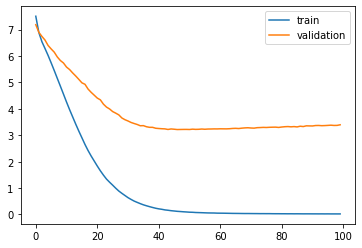

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [137]:
def get_word(n, tokenizer):
    index = n.argmax()
    for word, i in tokenizer.word_index.items():
        if i == index:
            return word
    return None

In [138]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], turkish_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], turkish_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [139]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [140]:
pred_df.head(20)

,actual,predicted
0,bu üç tür kararin gerekçeleri vermiş olduğum açiklamalar arasinda vardir,tür kararin gerekçeleri vermiş olduğum açiklamalar arasinda vardir
1,bu inanca aykiri görüş ve düşünceleri açiğa vuracaklarin vay haline,aykiri görüş ve düşünceleri açiğa vuracaklarin vay haline
2,görüyordum iki üç bin mil açiktan bakarak,üç ayni üç girmelerinin son damlanin
3,hayir kendin bak,hayir kendin bak
4,kuzum eşek nali yapsan bir usta çingenenin,kuzum eşek nali yapsan bir çingenenin
5,cetelerimizden bir kismi yok ediliyor,bir şeyi içinde istemiş
6,cünkü sorun gerçekten önemli ve ölüm kalim sorunu niteliğindeydi,cünkü bunlar ortadan güven elverişli olabilir
7,649,
8,ben bu ödevin yapilmasinin bir görev ve yetki sahibi olmaya bağli olduğunu ileri sürdüm,ve tam içinde olmasi zorunlu verdik
9,bana bu söylediğim şeyleri tümüyle kabullendi,bana bu söylediğim şeyleri tümüyle kabullendi


In [141]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [142]:
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [143]:
from nltk.translate.bleu_score import corpus_bleu
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

In [144]:
# Compute the BLEU Score
bleu_test = bleu_score(model, turkish_tokenizer, testX, test)

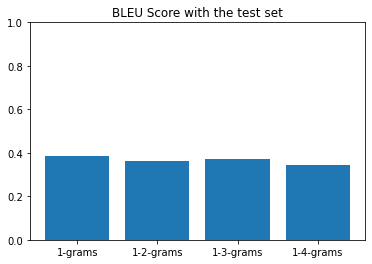

In [146]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()